In [1]:
!pip install openfermion sparse

### Código base de OpenFermion, hay mucho al pedo

In [2]:
import numpy as np
import openfermion as of
from tqdm import tqdm
from itertools import combinations
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
import functools
import concurrent.futures
from numba import njit
import tensorflow as tf
import scipy
import sparse
import itertools

# Generación de base
class fixed_basis:
    @staticmethod
    def int_to_bin(k, d):
        return np.base_repr(k, 2).zfill(d)

    @staticmethod
    def bin_to_op(b):
        tups = [(i, 1) for i, k in list(enumerate(list(b))) if k == '1']
        return of.FermionOperator(tups)

    def idx_to_repr(self, idx):
        return self.canonicals[idx]

    def opr_to_idx(self, opr):
        for i in range(self.size): # Evitar esto ordenando opr
            if self.base[i] == opr:
                return i

    # Calcula el valor medio a partir del indice del vector y el operador
    def idx_mean_val(self, idx: int, op: of.FermionOperator):
        vec = self.idx_to_repr(idx)
        return np.real(np.transpose(vec) @ of.get_sparse_operator(op, n_qubits=self.d) @ vec)

    # Calcula el valor medio a partir de un estado y el operador
    def mean_val(self, vec, op):
        idx = self.opr_to_idx(vec)
        return self.idx_mean_val(idx, op)

    # Calcula la contracción de un operador sobre dos estados dados
    def idx_contraction(self, idx_1, idx_2, op):
        rep = lambda x: self.idx_to_repr(x)
        return np.real(np.transpose(rep(idx_1)) @ of.get_sparse_operator(op, n_qubits=self.d) @ rep(idx_2))

    def create_basis(self, d, num = None, pairs = False):
        basis = []
        num_ele = []
        for k in range(0,2**d):
            b = self.int_to_bin(k, d)
            if num != None:
                if b.count('1') == num:
                    if pairs:
                        if np.all(b[::2] == b[1::2]):
                            oper = self.bin_to_op(b)
                            basis.append(oper)
                            num_ele.append(k)
                    else:
                        oper = self.bin_to_op(b)
                        basis.append(oper)
                        num_ele.append(k)
            else:
                oper = self.bin_to_op(b)
                basis.append(oper)
        return basis, num_ele

    def __init__(self, d, num = None, pairs = False):
        self.d = d
        self.num = num
        self.m = num
        self.base, self.num_ele = self.create_basis(d, num, pairs)
        self.size = len(self.base)
        self.canonicals = np.eye(self.size)
        self.pairs = pairs

    @staticmethod
    def cdc(i, j):
        return of.FermionOperator(((i,1),(j,0)))

    @staticmethod
    def cc(i, j):
        return of.FermionOperator(((i,0),(j,0)))

    # Del indice, cuenta el número de partículas
    def num_idx(self, idx):
        b = self.int_to_bin(idx, basis.d)
        return b.count('1')

    # Calculo de rho1 (via directa, lento, y solo definido en la base por ahora)
    def rho_1(self, op):
        # Necesitamos un índice, es?
        if type(op) != int:
            op = self.opr_to_idx(op)
        mat = np.zeros((self.d, self.d))
        for i in range(self.d):
            for j in range(self.d):
                cdc = self.cdc(j, i)
                mat[i,j] = self.idx_mean_val(op, cdc)
        return mat

# Calculo de generadores de rho1
def rho_1_gen(basis):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    indices = []
    values = []
    shape = (basis.d, basis.d, basis.size, basis.size)
    d = basis.d
    for i in tqdm(range(0, d)):
        for j in range(0, d):
            # Generamos el operador
            op = basis.cdc(j, i)
            #print(op)
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)
    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

# Calculo de rho1 (via generadores) de un vector en la base canonica
def rho_1(vect, rho_1_arrays):
    if len(vect.shape) == 1: # vectores
        return sparse.einsum('k,ijkl,l->ij', vect, rho_1_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad
        return sparse.einsum('ijkl,kl->ij', rho_1_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_1_arrays)

# Calculo de indices de rho2kkbar
def get_kkbar_indices(t_basis):
    indices = []
    for i, ind in enumerate(t_basis.num_ele):
        v = t_basis.int_to_bin(ind, t_basis.d)
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

# Calculo de generadores de rho2
def rho_2_gen(basis, t_basis, idx_list = []):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    indices = []
    values = []
    if len(idx_list) == basis.m:
        idx_list = idx_list
    elif len(idx_list) == basis.m**4:
        idx_list = np.unique(idx_list[:,0])
    else:
        idx_list = range(t_basis.size)
    shape = (len(idx_list), len(idx_list), basis.size, basis.size)
    for i, ii in tqdm(enumerate(idx_list), total=len(idx_list)):
        for j, jj in enumerate(idx_list):
            # Generamos el operador
            op = t_basis.base[jj]*of.utils.hermitian_conjugated(t_basis.base[ii])
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)

    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

def rho_m_gen(basis, m):
    indices = []
    values = []
    m_basis = fixed_basis(basis.d, num=m, pairs=basis.pairs)
    shape = (m_basis.size, m_basis.size, basis.size, basis.size)
    
    it_set = np.arange(m_basis.size) #[::-1]
    for i, ii in tqdm(enumerate(it_set), total=m_basis.size):
        for j, jj in enumerate(it_set):
            # Generamos el operador
            op = m_basis.base[jj]*of.utils.hermitian_conjugated(m_basis.base[ii])
            mat = np.real(of.get_sparse_operator(op, n_qubits=basis.d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)

    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

def rho_m(vect, rho_m_arrays):
    return sparse.einsum('k,ijkl,l->ij', vect, rho_m_arrays, vect)

# Calculo de rho2 (via generadores) de un estado en la base canonica
def rho_2(vect, rho_2_arrays):
    if len(vect.shape) == 1: # vectores SOLO RHO2 COMPLETA
        return sparse.einsum('k,ijkl,l->ij', vect, rho_2_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad SOLO RHO2 COMPLETA
        return sparse.einsum('ijkl,kl->ij', rho_2_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_2_arrays)

# Calculo de generadores de K (usado para quasiparticles) WIP SPARSE
def k_gen(basis):
    mat = np.zeros((basis.d, basis.d, basis.size, basis.size))
    d = basis.d
    for i in tqdm(range(0, d), total=d):
        for j in range(0, d):
            op = basis.cc(j, i)
            if basis.num == None:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()
            else:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()[np.ix_(basis.num_ele, basis.num_ele)]
    return mat

def k_vect(vect, k_gen):
    return np.einsum('k,ijkl,l->ij', vect, k_gen, vect)

# Calculo la matrix rho de cuasipartículas  WIP SPARSE
def rho_qsp(vect, rho_1_arrays, k_arrays, rho1 = None):
    if type(rho1) == None:
        rho1 = rho_1(vect, rho_1_arrays)
    k = k_vect(vect, k_arrays)

    mat = np.block([[rho1, k], [-np.conjugate(k), np.eye(rho_1_arrays.shape[0])-np.conjugate(rho1)]])
    return mat

# Devuelve los indices que tienen a level ocupado
def level_proy(d, level):
    ids = []
    for k in range(0,2**d):
        b = fixed_basis.int_to_bin(k, d)
        if b[level] == '1':
            ids.append(k)
    arr = np.zeros(2**d)
    arr[np.array(ids)] = 1
    return arr, ids

def parity_levels(d):
    rng = range(2**d)
    binary_repr = np.vectorize(np.binary_repr)(rng)
    ones_c = np.char.count(binary_repr, '1')
    return np.array(rng)[ones_c % 2 == 1] # seleccionamos estados impares

# Devuelve el vector postmedido
def measure(basis, vect, level = 1):
    l_arr, l_ids = level_proy(basis.d, level)
    proy_v = vect * l_arr
    comp_arr = np.logical_not(l_arr).astype(int)
    comp_v = vect * comp_arr
    norm = lambda v: v / np.linalg.norm(v)
    return norm(proy_v), norm(comp_v)

def entropy(rho, m):
    rho_log = scipy.linalg.logm(rho) / np.log(2)
    ent = -1*np.trace(rho @ rho_log)
    dm = scipy.special.binom(basis.d, m)

    return ent / dm

2024-12-14 21:21:29.981145: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 21:21:30.067845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 21:21:30.148599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734211290.221628     974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734211290.242852     974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 21:21:30.412034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Hamiltoniano

In [3]:
def two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays, h_type = None, indices = None):
    # SECCIÓN ENERGIAS
    ## Dado un seed de niveles diagonal construimos la mat simétrica dxd que multiplicara a c^dag_i c_j
    diagonal = np.zeros((gpu_batch_size, basis.d, basis.d))
    diagonal[:, np.arange(basis.d), np.arange(basis.d)] = energy_seed
    ## Convertimos en sparse la energia y la expandimos
    energy_matrix = sparse.COO.from_numpy(diagonal)
    energy_matrix_expanded = energy_matrix[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = rho_1_arrays.transpose(axes=[1, 0, 2, 3])
    # Multiplicamos por los operadores C^dag C
    matprod = energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:]
    h0_arr = matprod.sum(axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados

    # Creamos la mat de t_basis, nada más que hacer! los coeficientes están dados. Bueno, y simetrizar
    i_shape = basis.m**2 if h_type == 'blockgen' else t_basis.size
    int_mat = np.zeros((gpu_batch_size, i_shape, i_shape))

    # Si nos dieron indices, debemos llevar el G_arr (d,d) -> (t_basis.size, t_basis.size)
    ## Caso kkbar (el único con índices)
    if indices != None and len(indices) == basis.m:
        indices = np.array(indices)
        int_mat[:, indices[:, None], indices[None, :]] = G_batched
    elif h_type == 'randomenerg' or h_type == 'blockgen':
        idx = np.triu_indices(i_shape)
        int_mat[:, idx[0], idx[1]] = G_batched
    else:
        raise ValueError
    diagonal = np.einsum('ijk,ijk->ijk', int_mat, np.eye(i_shape)[np.newaxis,::])
    int_mat = int_mat + np.transpose(int_mat, axes=(0,2,1)) - diagonal
    int_mat = sparse.COO.from_numpy(int_mat)

    # Preparamos las dimensiones y multiplicamos
    int_mat_expanded = int_mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = rho_2_arrays.transpose(axes=[1, 0, 2, 3])
    matprod = int_mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:]
    hi_arr = matprod.sum(axis=[1,2])

    return h0_arr - hi_arr


def state_energy(state, h_arr):
    return tf.linalg.trace(tf.matmul(state, h_arr))


## Main

In [4]:
#### INIT ####
d = 8
num = d//2 # En caso de ser None, es GC
pairs = False
m = 2

# Bases
basis = fixed_basis(d, num=num, pairs=pairs)
t_basis = fixed_basis(d, num=2)
# Arrays
#ray.init(ignore_reinit_error=True, num_cpus=16)
rho_1_arrays = rho_m_gen(basis, 1)
rho_2_arrays = rho_m_gen(basis, 2)
rho_arrays = rho_m_gen(basis, m)
#ray.shutdown()
# Indices
k_indices = get_kkbar_indices(t_basis)
# Arrays reducidos
rho_2_kkbar_arrays = rho_2_gen(basis, t_basis, idx_list = k_indices)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.42it/s]


In [26]:
compute_g(1)

(1,
 array([0.04533639, 0.12045311, 0.40426328, 1.42994722]),
 0.7966454695041051)

0.0
0.2631578947368421
0.5263157894736842
0.7894736842105263
1.0526315789473684
1.3157894736842104
1.5789473684210527
1.8421052631578947
2.1052631578947367
2.3684210526315788
2.631578947368421
2.894736842105263
3.1578947368421053
3.4210526315789473
3.6842105263157894
3.9473684210526314
4.2105263157894735
4.473684210526316
4.7368421052631575
5.0


/home/debian/anaconda3/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:203: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


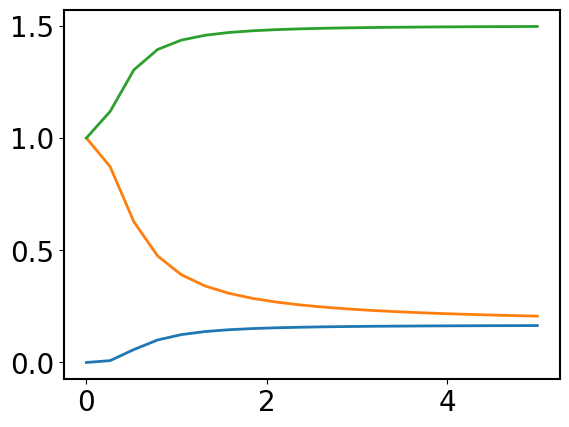

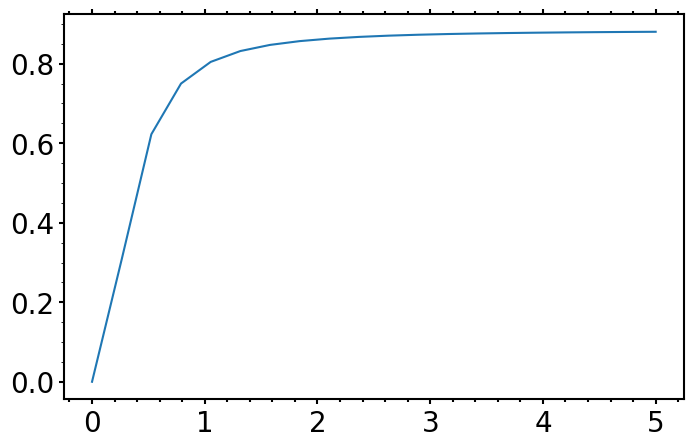

In [59]:
# Hamiltoniano
def compute_g(g):
    # Eigenvals
    en_batch = [np.repeat(np.arange(0, basis.num) - basis.num//2 + 1/2, 2) for _ in range(0,1)] # Semilla para H equiespaciado
    energy_seed = en_batch
    G_batched = [g * np.ones((basis.m,basis.m)) for _ in range(0, 1)]
    h = two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays, h_type = 'const', indices = k_indices)
    h = h.todense()
    fund = np.linalg.eigh(h[0,:,:])[1][:,0]
    rho = rho_m(fund, rho_2_kkbar_arrays).todense()
    r = np.sort(np.linalg.eigvals(rho).real)

    # Entropy
    rho1 = rho_m(fund, rho_1_arrays).todense()
    rho2 = rho_m(fund, rho_2_arrays).todense()

    e = entropy(rho1, 1) + entropy(rho2, 2)
    #print(r)
    return (g, r, e)

rho_range = []
num = 20

g_range = np.linspace(0,5,num)
gpu_batch_size = 1
for g in g_range:
    print(g)
    rho_range.append(compute_g(g))

# Ploteamos
x_axis = list(g_range)
size = len(rho_range[0][1])
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# Plot using matplotlib
# Use LaTeX to format all text

plt.rcParams['text.usetex'] = False #True
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.linewidth'] = 1.5



plt.close()
plt.clf()
#plt.figure(figsize=(8, 5))
#%matplotlib qt
%matplotlib inline
for k in range(1,size):
    plt.plot(x_axis, [rho_range[j][1][k] for j in range(0,num)], linewidth=2)


plt.figure(figsize=(8, 5))
plt.plot(x_axis, [rho_range[x][2] for x in range(0, num)])

#plt.xlabel(r'$G/\epsilon$', fontsize=18)
#plt.ylabel(r'$\lambda^{(2)}$', fontsize=18)
#plt.xlim(0, 5)  # Set x-axis limits from 0 to 6
#plt.ylim(0, 5)  # Set y-axis limits from 5 to 12

#matplotlib.use('Agg')
#matplotlib.use('GTK3Agg')

plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)

# Enable minor ticks on the x-axis
plt.minorticks_on()

# Customize the appearance of minor ticks on the x-axis
plt.tick_params(axis='x', which='minor', width=1.5)
plt.tick_params(axis='x', which='major', width=1.5)
plt.tick_params(axis='y', which='major', width=1.5)

plt.show()
#matplotlib.pyplot.savefig('filename.png')


In [54]:
rho_range[0][2]

-0.0

In [51]:
[rho_range[k][1][2] for k in range(num)]

[1.0,
 0.8724360945118453,
 0.626920337885958,
 0.4747373507950439,
 0.39097364276931124,
 0.3409031134725585,
 0.3083229882323942,
 0.2856676402825099,
 0.26909422220370305,
 0.25648487954684224,
 0.24658966670952856,
 0.2386281990175808,
 0.23209015872471245,
 0.22662872369141243,
 0.222000417773329,
 0.21802953258111274,
 0.2145862196137417,
 0.2115725229622916,
 0.20891320067299554,
 0.2065495304563284]

In [106]:
"""
import numpy as np
import ray
from tqdm import tqdm
import sparse
import openfermion as of


@ray.remote
def process_rho_m(chunk, m_basis_ref, basis_ref, d):
    indices = []
    values = []
    print(m_basis_ref, basis_ref)
    #basis = ray.get(basis_ref)
    #m_basis = ray.get(m_basis_ref)

    for ii in chunk:
        for jj in range(m_basis.size):
            # Generate the operator
            op = m_basis.base[jj] * of.utils.hermitian_conjugated(m_basis.base[ii])
            mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extract the information
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([ii, jj, r, c])
                values.append(v)

    return indices, values


def rho_m_gen(basis, m, num_workers=4):
    indices = []
    values = []
    m_basis = fixed_basis(basis.d, num=m, pairs=basis.pairs)
    m_basis_ref = ray.put(m_basis)
    basis_ref = ray.put(basis)
    shape = (m_basis.size, m_basis.size, basis.size, basis.size)
    chunks = np.array_split(range(m_basis.size), num_workers)

    futures = [
        process_rho_m.remote(chunk, m_basis_ref, basis_ref, basis.d)
        for chunk in chunks
    ]

    results = list(tqdm(ray.get(futures), total=num_workers))
    for indices_chunk, values_chunk in results:
        indices.extend(indices_chunk)
        values.extend(values_chunk)


    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t
"""

'\nimport numpy as np\nimport ray\nfrom tqdm import tqdm\nimport sparse\nimport openfermion as of\n\n\n@ray.remote\ndef process_rho_m(chunk, m_basis_ref, basis_ref, d):\n    indices = []\n    values = []\n    print(m_basis_ref, basis_ref)\n    #basis = ray.get(basis_ref)\n    #m_basis = ray.get(m_basis_ref)\n\n    for ii in chunk:\n        for jj in range(m_basis.size):\n            # Generate the operator\n            op = m_basis.base[jj] * of.utils.hermitian_conjugated(m_basis.base[ii])\n            mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]\n            # Extract the information\n            n_r, n_c = mat.nonzero()\n            data = mat.data\n            for r, c, v in zip(n_r, n_c, data):\n                indices.append([ii, jj, r, c])\n                values.append(v)\n\n    return indices, values\n\n\ndef rho_m_gen(basis, m, num_workers=4):\n    indices = []\n    values = []\n    m_basis = fixed_basis(basis.d, num=m, pairs=basi